# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Thu Feb 15 20:57:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 11.4 MB/s eta 0:00:00


In [3]:
# Import torch
import torch
from torchmetrics import Accuracy

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.1.0+cu121


In [4]:
device

'cuda'

## 1. What are 3 areas in industry where computer vision is currently being used?

- Object Classification with images
- Object Detection
- Object Segmentation

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

**Answer:** Overfitting is when a model learns exactly how to interpretate data and cannot extrapolate and generalize with data outside the train data.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

* Split data: Generally the data is splitted between 80% train data and 20% test data.
* Data augmentation: Increase the samples by using transformers in the data. This means that could be rotated, change colors or applying zoom.
* Use cross-validation. The data is splitted in k folds, where the folds used for testing are rotated among the iterations or epochs to allow the model to learn all the data.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [5]:
import torchvision
from torchvision.transforms import ToTensor

train_data = torchvision.datasets.MNIST(root='.',
                                  train=True,
                                  download=True,
                                  transform=ToTensor())

test_data = torchvision.datasets.MNIST(root='.',
                                  train=False,
                                  download=True,
                                  transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 142682597.12it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39965586.88it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41497008.26it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5348267.48it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [6]:
print(f"Size of train data: {len(train_data)}")
print(f"Size of test data: {len(test_data)}")

Size of train data: 60000
Size of test data: 10000


In [7]:
img, label = train_data[0]
img.shape

torch.Size([1, 28, 28])

In [8]:
labels_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}

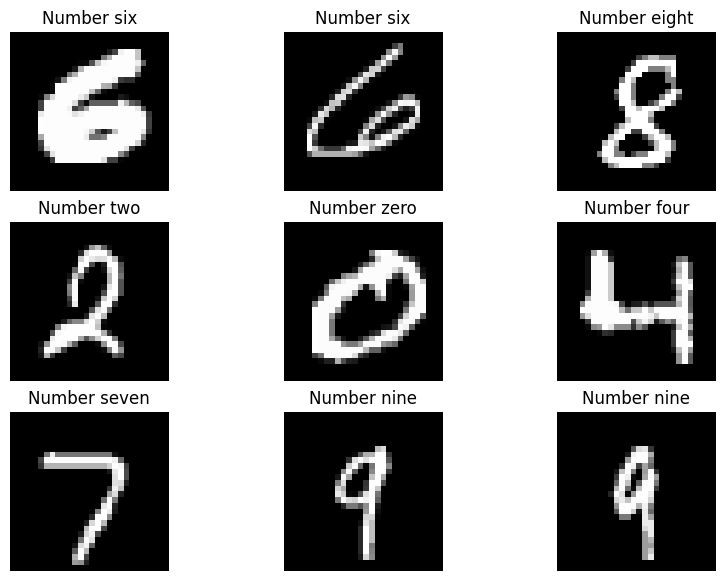

In [9]:
import matplotlib.pyplot as plt

torch.manual_seed(42)

plt.figure(figsize=(10,7))
idx = 1
n_rows, n_columns = 3, 3
for i in torch.randint(0, len(train_data), (9,)):
  img, label = train_data[i]
  plt.subplot(n_rows, n_columns, idx)
  plt.imshow(img.permute(1,2,0), cmap='gray')
  plt.axis(False)
  plt.title(f"Number {labels_map[label].lower()}")
  idx += 1

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [11]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 1, 28, 28])

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [12]:
import torch.nn as nn

class CNNModel(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_features, kernel_size):
    super().__init__()
    self.conv1 = nn.Sequential(
              nn.Conv2d(
                  in_channels=in_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size
              ),
              nn.ReLU(),
              nn.Conv2d(
                  in_channels=hidden_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size
              ),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size)
            )
    self.conv2 = nn.Sequential(
              nn.Conv2d(
                  in_channels=hidden_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size
              ),
              nn.ReLU(),
              nn.Conv2d(
                  in_channels=hidden_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size
              ),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size)
            )
    self.classificate = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_channels*5*5,
                  out_features=out_features)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.classificate(x)
    return x

In [13]:
model = CNNModel(in_channels=1, hidden_channels=16, out_features=len(train_data.classes), kernel_size=2).to(device)
model

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classificate): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [27]:
img_sample = torch.randn((1,28,28)).unsqueeze(dim=0).to(device)
model(img_sample)

tensor([[-3.1205, -3.3344,  0.6555,  1.7086,  2.0309,  2.3470, -0.8208,  0.7767,
          7.1584, -6.9251]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.1)

In [16]:
accuracy = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)

In [17]:
epochs = 5
for epoch in range(epochs):

  softmax = nn.Softmax(dim=1)
  total_loss = 0
  total_acc = 0

  model.train()

  for batch, (X, y) in enumerate(train_dataloader):

    # Transfer the data to device
    X, y = X.to(device), y.to(device)

    #1. Forward pass
    train_y_logits = model(X)
    train_y_probs = softmax(train_y_logits)
    train_y_preds = torch.argmax(train_y_probs, dim=1)

    #2. Calculate the loss
    loss = loss_fn(train_y_logits, y)
    total_loss += loss

    acc = accuracy(train_y_preds, y)
    total_acc += acc

    #3. Zero grad
    optimizer.zero_grad()

    #4. Backward propagation
    loss.backward()

    #5. Step
    optimizer.step()

  train_loss = total_loss / len(train_dataloader)
  train_acc = total_acc / len(train_dataloader)

  model.eval()

  total_loss = 0
  total_acc = 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):

      # Convert to device
      X, y = X.to(device), y.to(device)

      #1. Forward pass
      test_y_logits = model(X)
      test_y_probs = softmax(test_y_logits)
      test_y_preds = torch.argmax(test_y_probs, dim=1)

      #2. Loss
      total_loss += loss_fn(test_y_logits, y)

      acc = accuracy(test_y_preds, y)
      total_acc += acc

    test_loss = total_loss / len(test_dataloader)
    test_acc = total_acc / len(test_dataloader)


  print(f"Epoch: {epoch + 1} | Train loss: {train_loss} | Train accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}")

Epoch: 1 | Train loss: 0.2813401520252228 | Train accuracy: 0.9094499945640564 | Test loss: 0.0831524133682251 | Test accuracy: 0.9720447063446045
Epoch: 2 | Train loss: 0.0817694440484047 | Train accuracy: 0.9751999974250793 | Test loss: 0.061769936233758926 | Test accuracy: 0.9789336919784546
Epoch: 3 | Train loss: 0.06362249702215195 | Train accuracy: 0.9801499843597412 | Test loss: 0.06316813826560974 | Test accuracy: 0.9780351519584656
Epoch: 4 | Train loss: 0.05417579412460327 | Train accuracy: 0.9829166531562805 | Test loss: 0.04665191099047661 | Test accuracy: 0.9842252135276794
Epoch: 5 | Train loss: 0.04749424383044243 | Train accuracy: 0.985366702079773 | Test loss: 0.047359056770801544 | Test accuracy: 0.9841253757476807


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [25]:
X,y = test_data[0]
X.shape

torch.Size([1, 28, 28])

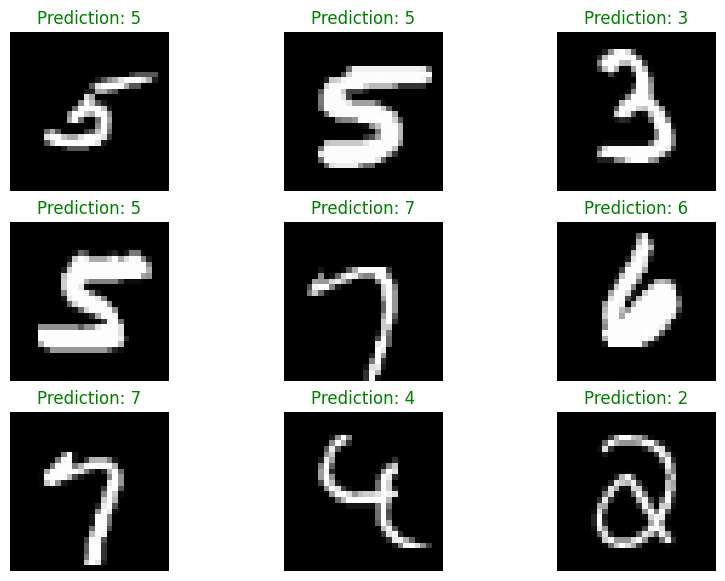

In [49]:
torch.manual_seed(42)

random_index = torch.randint(0, len(test_data), (9,))

model.eval()

with torch.inference_mode():

  plt.figure(figsize=(10,7))
  n_rows, n_columms = 3, 3
  idx = 0

  for i in random_index:

    X, y = test_data[i]
    X = X.to(device)

    # Forward pass
    y_logits = model(X.unsqueeze(dim=1))
    y_probs = softmax(y_logits)
    y_preds = torch.argmax(y_probs, dim=1)

    plt.subplot(n_rows, n_columns, idx+1)
    plt.imshow(X.permute(1,2,0).cpu(), cmap = 'gray')
    plt.axis(False)
    if y_preds.item() == y:
      plt.title(f"Prediction: {y_preds.item()}", color='green')
    else:
      plt.title(f"Prediction: {y_preds.item()} | Real: {y}", color='red')

    idx += 1

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [91]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(train_data.classes)).to('cpu')

In [92]:
test_data.data.unsqueeze(dim=1).shape

torch.Size([10000, 1, 28, 28])

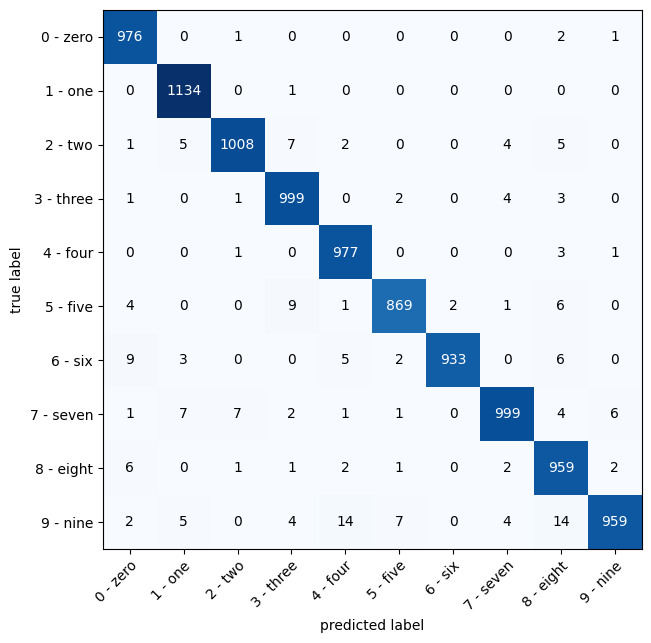

In [93]:
with torch.inference_mode():

  X, y = test_data.data, test_data.targets
  X, y = X.to(device), y.to(device)

  y_logits = model(X.unsqueeze(dim=1).to(torch.float))
  y_probs = softmax(y_logits)
  y_preds = torch.argmax(y_probs, dim=1)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat(y_preds.cpu(), y.cpu()).numpy(), # matplotlib likes working with NumPy
    class_names=train_data.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [94]:
fashion_train_data = torchvision.datasets.FashionMNIST(root='data',
                                                       train=True,
                                                       transform=ToTensor(),
                                                       download=True)

fashion_test_data = torchvision.datasets.FashionMNIST(root='data',
                                                       train=False,
                                                       transform=ToTensor(),
                                                       download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12351353.69it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212430.04it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3902834.64it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20160856.20it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [96]:
print(f"Size of train data: {len(fashion_train_data)} | Size of test data: {len(fashion_test_data)}")

Size of train data: 60000 | Size of test data: 10000


In [105]:
fashion_train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [111]:
labels_dict = {v: k for k, v in fashion_train_data.class_to_idx.items()}

'Ankle boot'

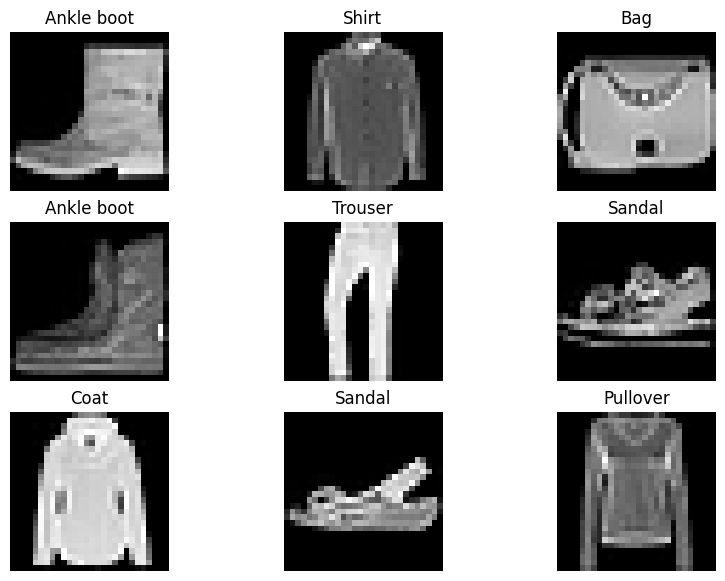

In [115]:
torch.manual_seed(42)

plt.figure(figsize=(10,7))
n_rows, n_columns = 3, 3
idx = 1

for i in torch.randint(0, len(fashion_train_data), (9,)):
  img, label = fashion_train_data[i]
  plt.subplot(n_rows, n_columns, idx)
  plt.imshow(img.permute(1,2,0), cmap='gray')
  plt.axis(False);
  plt.title(labels_dict[label]);
  idx += 1

In [133]:
class FashionMNISTModel(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, kernel_size):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=kernel_size)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_channels,
                  out_channels=hidden_channels,
                  kernel_size=kernel_size),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=kernel_size)
    )
    self.classify = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_channels*5*5,
                  out_features=out_channels)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.classify(x)
    return x

In [134]:
model = FashionMNISTModel(in_channels = 1,
                          hidden_channels = 32,
                          out_channels = len(fashion_test_data.classes),
                          kernel_size = 2).to(device)
model

FashionMNISTModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=800, out_features=10, bias=True)
  )
)

In [135]:
sample_X, sample_y = fashion_train_data[0]
model(sample_X.unsqueeze(dim=1).to(device))
sample_X.shape

torch.Size([1, 28, 28])

In [136]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=fashion_train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=fashion_test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

## Train the model

In [139]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)
accuracy = Accuracy(task="multiclass", num_classes=len(fashion_train_data.classes)).to(device)

In [145]:
def train_step(model, dataloader, device):

  model.train()

  total_loss = 0
  total_acc = 0

  for batch, (X, y) in enumerate(dataloader):

    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_logits = model(X)
    y_probs = softmax(y_logits)
    y_preds = torch.argmax(y_probs, dim=1)

    # 2. Metric
    loss = loss_fn(y_logits, y)
    total_loss += loss

    total_acc += accuracy(y_preds, y)

    # 3. Zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Step
    optimizer.step()

  train_loss = total_loss / len(dataloader)
  train_acc = total_acc / len(dataloader)

  return train_loss, train_acc

In [143]:
def test_step(model, dataloader, device):

  model.eval()

  total_loss = 0
  total_acc = 0

  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataloader):

      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_logits = model(X)
      y_probs = softmax(y_logits)
      y_preds = torch.argmax(y_probs, dim=1)

      # 2. Metric
      total_loss += loss_fn(y_logits, y)
      total_acc += accuracy(y_preds, y)

    return train_loss, train_acc


In [147]:
epochs = 5

for epoch in range(epochs):

  train_loss, train_acc = train_step(model, train_dataloader, device)
  test_loss, test_acc = test_step(model, test_dataloader, device)

  print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc * 100:.2f}% | Test loss: {test_loss:.4f} | Test accuracy: {test_acc*100:.2f}%")


Epoch: 1 | Train loss: 0.3830 | Train accuracy: 86.0050% | Test loss: 0.3830 | Test accuracy: 86.0050%
Epoch: 2 | Train loss: 0.3351 | Train accuracy: 87.7667% | Test loss: 0.3351 | Test accuracy: 87.7667%
Epoch: 3 | Train loss: 0.3074 | Train accuracy: 88.8417% | Test loss: 0.3074 | Test accuracy: 88.8417%
Epoch: 4 | Train loss: 0.2882 | Train accuracy: 89.5667% | Test loss: 0.2882 | Test accuracy: 89.5667%
Epoch: 5 | Train loss: 0.2731 | Train accuracy: 90.0783% | Test loss: 0.2731 | Test accuracy: 90.0783%


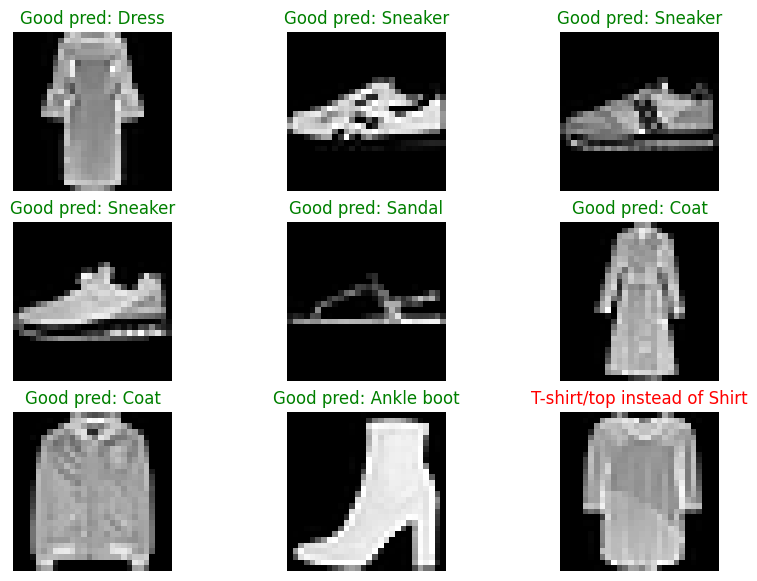

In [158]:
# torch.manual_seed(42)

random_idx = torch.randint(0, len(fashion_test_data), (9,))
idx = 1
plt.figure(figsize=(10,7))
n_rows, n_columns = 3, 3

for i in random_idx:
  img, truth_label = fashion_test_data[i]

  model.eval()

  with torch.inference_mode():
    y_logit = model(img.to(device).unsqueeze(dim=1)).to(device)
    y_pred = torch.argmax(softmax(y_logit), dim=1)

  label_pred = labels_dict[y_pred.item()]

  plt.subplot(n_rows, n_columns, idx)
  plt.imshow(img.permute(1,2,0), cmap='gray')
  plt.axis(False)
  if y_pred.item() == truth_label:
    plt.title(f"Good pred: {label_pred}", color='green')
  else:
    plt.title(f"{label_pred} instead of {labels_dict[truth_label]}", color='red')
  idx += 1